In [1]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fish-1/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])

for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:25<00:00,  2.33s/it]

DONE!


In [2]:
# =========================================================
# IMPORTS
# =========================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [3]:
# =========================================================
# DINO STYLE AUGMENTATIONS
# =========================================================
class DINOTransform:
    def __init__(self, global_crops_scale=(0.4, 1.0), local_crops_scale=(0.05, 0.4)):
        self.global_transform = T.Compose([
            T.RandomResizedCrop(224, scale=global_crops_scale),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.RandomGrayscale(0.2),
            T.ToTensor()
        ])

        self.local_transform = T.Compose([
            T.RandomResizedCrop(96, scale=local_crops_scale),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.RandomGrayscale(0.2),
            T.ToTensor()
        ])

    def __call__(self, x):
        global1 = self.global_transform(x)
        global2 = self.global_transform(x)
        local1  = self.local_transform(x)
        local2  = self.local_transform(x)
        return (global1, global2, local1, local2)


In [4]:
# =========================================================
# DINO Loss
# =========================================================
class DINOLoss(nn.Module):
    def __init__(self, out_dim=256, teacher_temp=0.04, student_temp=0.1):
        super().__init__()
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp
        self.center = torch.zeros(1, out_dim).to(device)

    def forward(self, student_out, teacher_out):
        teacher_out = F.softmax((teacher_out - self.center) / self.teacher_temp, dim=-1)
        student_out = F.log_softmax(student_out / self.student_temp, dim=-1)

        loss = torch.mean(torch.sum(-teacher_out * student_out, dim=-1))
        return loss


In [5]:
# =========================================================
# EfficientNet Backbone + DINO Heads
# =========================================================
class DINOEffNet(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        self.head = nn.Linear(1280, out_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.flatten(1)
        return self.head(x)


In [6]:
# =========================================================
# DATASET LOADING
# =========================================================
dataset_path = "/kaggle/working/augmented"

transform = DINOTransform()
dataset = ImageFolder(dataset_path, transform=transform)

loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
print("Classes:", dataset.classes)


Classes: ['Baim', 'Bata', 'Batasio(tenra)', 'Chitul', 'Croaker(Poya)', 'Hilsha', 'Kajoli', 'Meni', 'Pabda', 'Poli', 'Puti', 'Rita', 'Rui', 'Rupchada', 'Silver Carp', 'Telapiya', 'carp', 'k', 'kaikka', 'koral', 'shrimp']


In [7]:
def train_dino(student, teacher, loader, loss_fn, epochs=50):
    optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
    losses = []

    for e in range(epochs):
        epoch_loss = 0
        bar = tqdm(loader, desc=f"Epoch {e+1}/{epochs}")

        for (g1, g2, l1, l2), _ in bar:
            g1, g2, l1, l2 = g1.to(device), g2.to(device), l1.to(device), l2.to(device)

            # ----------- Student outputs -----------
            s_g1 = student(g1)
            s_g2 = student(g2)
            s_l1 = student(l1)
            s_l2 = student(l2)

            # Only 2 global views are used for loss
            student_out_global = torch.cat([s_g1, s_g2], dim=0)

            # ----------- Teacher outputs -----------
            with torch.no_grad():
                t_g1 = teacher(g1)
                t_g2 = teacher(g2)
                teacher_out_global = torch.cat([t_g1, t_g2], dim=0)

            # ----------- Compute DINO loss -----------
            loss = loss_fn(student_out_global, teacher_out_global)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Moving teacher towards student (EMA update)
            for p_s, p_t in zip(student.parameters(), teacher.parameters()):
                p_t.data = 0.996 * p_t.data + 0.004 * p_s.data

            epoch_loss += loss.item()

        losses.append(epoch_loss / len(loader))
        print("Loss:", losses[-1])

    return losses


In [8]:
temperatures = 0.1, 0.2, 0.5
all_losses = {}

for temp in temperatures:
    print(f"\n🔵 RUNNING DINO WITH TEMPERATURE = {temp}")

    student = DINOEffNet().to(device)
    teacher = DINOEffNet().to(device)

    # teacher weights freeze
    for p in teacher.parameters():
        p.requires_grad = False

    dino_loss = DINOLoss(student_temp=temp).to(device)
    losses = train_dino(student, teacher, loader, dino_loss, epochs=3)

    all_losses[temp] = (student, losses)

print("Training Complete!")



🔵 RUNNING DINO WITH TEMPERATURE = 0.1


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s] 
Epoch 1/3: 100%|██████████| 365/365 [04:47<00:00,  1.27it/s]


Loss: 3.0921472108527404


Epoch 2/3: 100%|██████████| 365/365 [04:41<00:00,  1.30it/s]


Loss: 1.351417154808567


Epoch 3/3: 100%|██████████| 365/365 [04:43<00:00,  1.29it/s]


Loss: 0.9384243545466906

🔵 RUNNING DINO WITH TEMPERATURE = 0.2


Epoch 1/3: 100%|██████████| 365/365 [04:42<00:00,  1.29it/s]


Loss: 2.5975039643784092


Epoch 2/3: 100%|██████████| 365/365 [04:40<00:00,  1.30it/s]


Loss: 0.8544838279077451


Epoch 3/3: 100%|██████████| 365/365 [04:43<00:00,  1.29it/s]


Loss: 0.5530821291142947

🔵 RUNNING DINO WITH TEMPERATURE = 0.5


Epoch 1/3: 100%|██████████| 365/365 [04:45<00:00,  1.28it/s]


Loss: 1.9539562796076684


Epoch 2/3: 100%|██████████| 365/365 [04:40<00:00,  1.30it/s]


Loss: 0.20598307432453722


Epoch 3/3: 100%|██████████| 365/365 [04:45<00:00,  1.28it/s]

Loss: 0.12277720905457662
Training Complete!


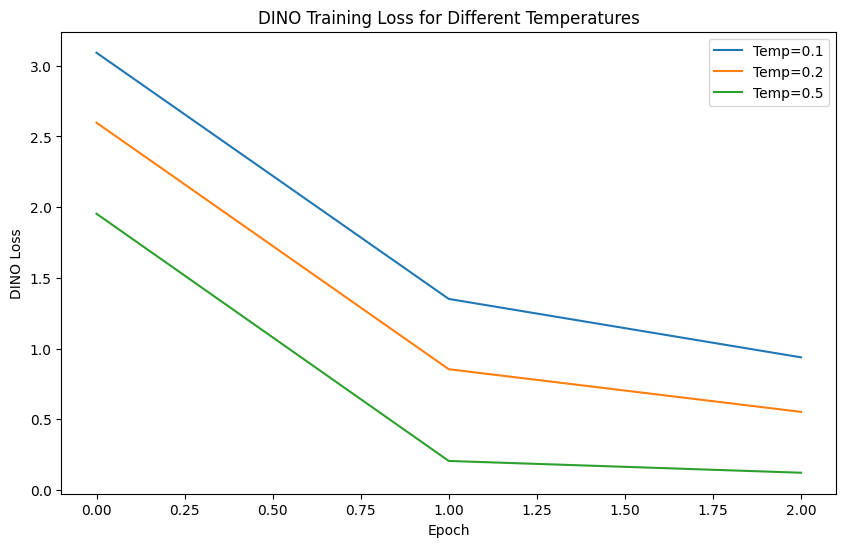

In [9]:
plt.figure(figsize=(10,6))
for temp, (_, loss) in all_losses.items():
    plt.plot(loss, label=f"Temp={temp}")

plt.xlabel("Epoch")
plt.ylabel("DINO Loss")
plt.title("DINO Training Loss for Different Temperatures")
plt.legend()
plt.show()


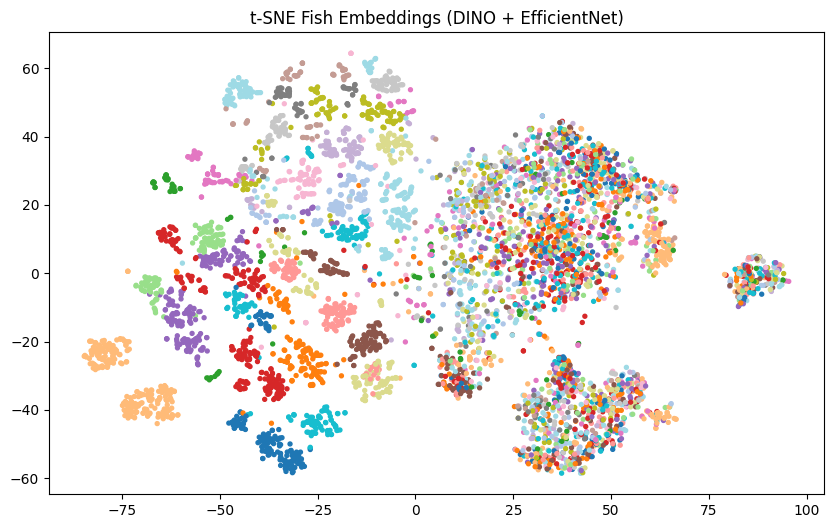

In [10]:
# Extract embeddings
def get_features(model, loader):
    model.eval()
    feats, labs = [], []
    with torch.no_grad():
        for (g1, _, _, _), lab in loader:
            g1 = g1.to(device)
            feat = model.feature_extractor(g1).flatten(1).cpu()
            feats.append(feat)
            labs.append(lab)
    return torch.cat(feats), torch.cat(labs)

student_model = all_losses[0.1][0]    # choose temp=0.1 model
features, labels = get_features(student_model, loader)

tsne = TSNE(n_components=2)
tsne_feats = tsne.fit_transform(features)

plt.figure(figsize=(10,6))
plt.scatter(tsne_feats[:,0], tsne_feats[:,1], c=labels, s=8, cmap="tab20")
plt.title("t-SNE Fish Embeddings (DINO + EfficientNet)")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


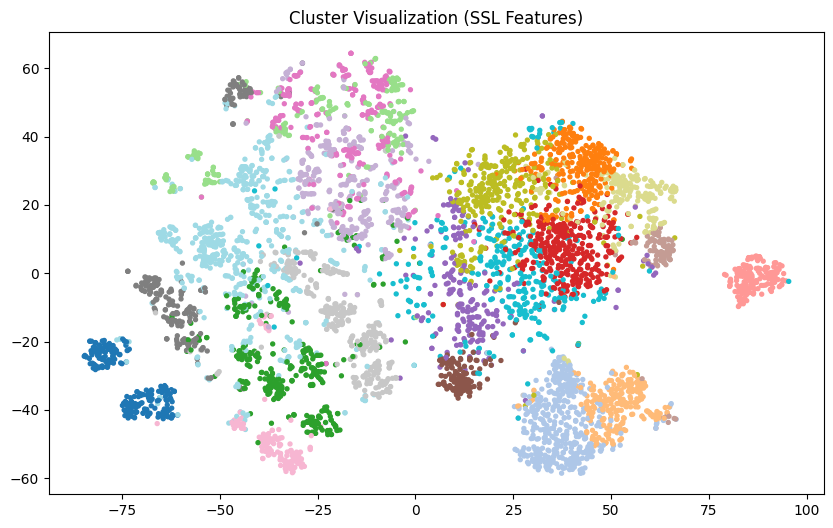

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=len(dataset.classes))
clusters = kmeans.fit_predict(features)

plt.figure(figsize=(10,6))
plt.scatter(tsne_feats[:,0], tsne_feats[:,1], c=clusters, s=8, cmap="tab20")
plt.title("Cluster Visualization (SSL Features)")
plt.show()


In [12]:
def show_attention(model, img_path):
    import cv2
    from torchvision.transforms import ToTensor, Resize
    import torch.nn.functional as F

    model.eval()

    # Load image
    img = cv2.imread(img_path)[:, :, ::-1]  # BGR->RGB
    img_resized = cv2.resize(img, (224, 224))

    img_tensor = ToTensor()(img_resized).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        feat = model.feature_extractor(img_tensor)  # shape: (1, 1280, 7, 7)
        attention = feat.squeeze(0).mean(0).cpu().numpy()  # mean across channels → (7,7)

    # Resize heatmap to original image size
    heatmap = cv2.resize(attention, (img.shape[1], img.shape[0]))

    # Plot
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(heatmap, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title("DINO Attention Heatmap")
    plt.show()


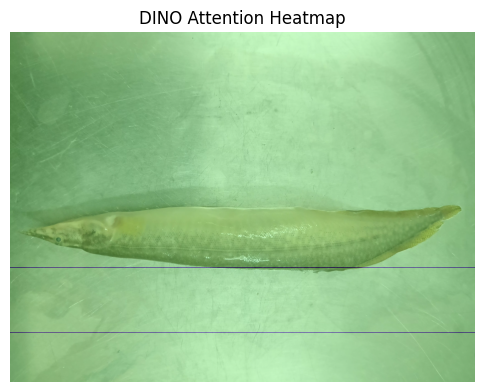

In [13]:
show_attention(
    student_model,
    "/kaggle/input/fish-1/Fishes/Baim/IMG20251101141601.jpg"
)


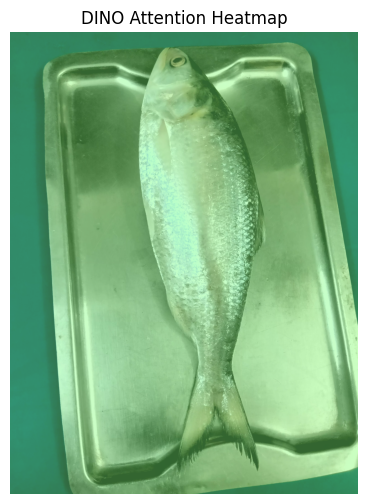

In [14]:
show_attention(
    student_model,
    "/kaggle/input/fish-1/Fishes/Hilsha/IMG20251019140358.jpg"
)


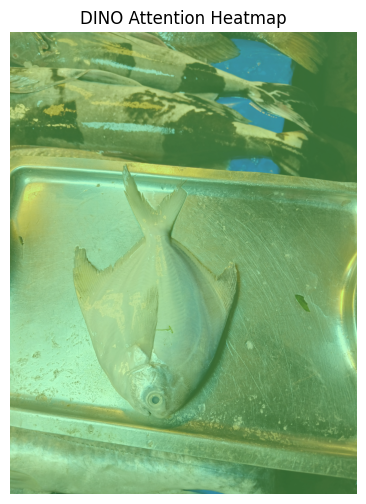

In [15]:
show_attention(
    student_model,
    "/kaggle/input/fish-1/Fishes/Rupchada/20251019_110547.jpg"
)
